# Auto-Regressive assimilation with EnIF

We illustrate `EnIF` methodology and the API through the Auto-Regressive-1 (AR-1) model.
The AR-1 is defined by
$$u_t = \phi u_{t-1} + \epsilon,~~
 \epsilon\sim N(0,1) $$
and has a tri-diagonal sparse precision matrix.

We will illustrate both the **high-level** API of EnIF, and also the **low-level** API.

## Imports

In [40]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
from graphite_maps.precision_estimation import precision_to_graph
from graphite_maps.enif import EnIF

We will repeatedly plot
- a realization
- an ensemble
- the ensemble mean
- the difference between posterior and prior mean

we thus create a function for this

In [41]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_ensemble(Ensemble, d, prior_mean=None):
    n, p = Ensemble.shape
    u_position = [j for j in range(p)]
    ind_obs = np.rint(p / 2).astype(int) - 1
    ensemble_mean = np.array(Ensemble.mean(axis=0))
    num_plots = 3 if prior_mean is None else 4
    
    fig = plt.figure(figsize=(16, 4))
    fig.suptitle('Ensemble inspection & observation', fontsize=16)

    ax = fig.add_subplot(1,num_plots,1)
    ax.plot(u_position, Ensemble[0,:])
    ax.plot(ind_obs, [d], marker='*', ls='none', ms=20)
    ax.set_title('Realization #1')
    
    ax = fig.add_subplot(1,num_plots,2)
    for i in range(n):
        ax.plot(u_position, Ensemble[i,:], label= "realization {ind}".format(ind=i), color=COLORS[0], alpha=0.1)
    ax.set_title('All realizations')
    ax.plot(ind_obs, [d], marker='*', ls='none', ms=20, color=COLORS[1])
    ax_min, ax_max = ax.get_ylim()  # Get y-limits
    
    ax = fig.add_subplot(1,num_plots,3)
    ax.plot(u_position, ensemble_mean)
    ax.plot(ind_obs, [d], marker='*', ls='none', ms=20)
    ax.set_title('Ensemble mean')

    if num_plots == 4:
        ax = fig.add_subplot(1,num_plots,4)
        ax.plot(u_position, ensemble_mean - prior_mean)
        ax.set_title('Posterior mean - prior mean')
    plt.show()

## Data setup: Auto-regressive simulation

We define the parameters of the ensemble based data assimilation with the AR-1
- `n`: ensemble or sample size. Increasing will increase the quality of the solution
- `p`: the number of AR-1 time-steps, here the dimensions of the problem. Increasing yields a more difficult problem. Traditional ensemble based methods would use localization to deal with high `p`.
- `phi`: between `-1` and `1`. `0` yields white noise without dependence. When `abs(phi)` is close to `1` there is strong dependence between dimensions.
- - Suggest to try `phi in [-0.99, 0.5, 0, 0.5, 0.99]` and inspect differences.

In [56]:
# Define parameters
n = 200  # Sample size
p = 1000  # Dimension
phi = 0.99

In [57]:
# Simulate data
def rar1(T, phi):
    """simulate auto-regressive-1.
    The first element is simulated from stationary distribution.
    """
    x = np.empty([T])
    x[0] = np.random.normal(0, 1 / np.sqrt(1 - phi**2))
    for i in range(1, T):
        x[i] = phi * x[i - 1] + np.random.normal(0, 1)
    return x

np.random.seed(42)
U = np.array([rar1(T=p, phi=phi) for _ in range(n)])

We here know the precision exactly, so we may compare our estimates. Note we derive the graph `Graph_u` from the precision, which we would normally just know apriori, while `Prec_u` would often (not always) be unknown.

In [58]:
# create AR-1 precision matrix
Prec_u = sp.sparse.diags(
    [np.repeat(-phi, p-1), np.concatenate(([1.0], np.repeat(1.0+phi**2, p-2), [1.0])), np.repeat(-phi, p-1)], 
    [-1,0,1], shape=(p, p), 
    format='csc'
)

# create corresponding graph -- often we only know this
Graph_u = precision_to_graph(Prec_u)

Create observations, `d`, that are associated with `u`.
We here pass a linear map `H` so that we model $d=Hu+\epsilon$, and $\epsilon$ has known precision.
Note that `H` may be learnt from data using the `fit_H` function.
We must then pass realizations `U` and simulated responses `Y`.

In [59]:
# create observation
d = np.array([30.0])
sd_eps = 1
H = np.array([0] * p, ndmin=2)
H[0, np.rint(p / 2).astype(int) - 1] = 1  # middle sencor
H = sp.sparse.csc_matrix(H)
Prec_eps = np.array([1/sd_eps**2], ndmin=2)
Prec_eps = sp.sparse.csc_matrix(Prec_eps)

In [60]:
# create responses
Y = U@H.T

Let's inspect the sample from the prior, and the observation `d`

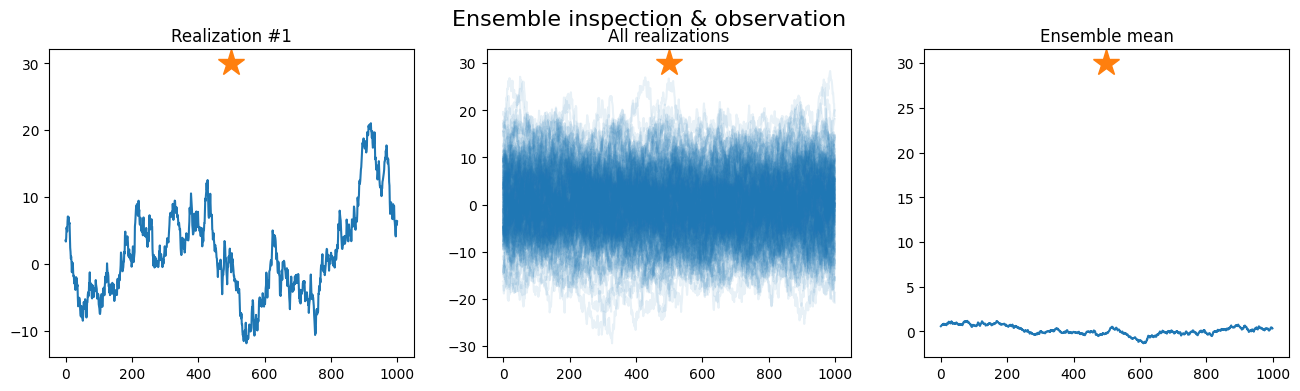

In [61]:
plot_ensemble(U, d)

## EnKF / Ensemble Smoother

In [62]:
def ES(U, Y, d, Cov_epsilon):
    # Cross-covariance matrix C_UY has shape (p, m)
    C_UY = np.dot((U - U.mean(axis=0)).T, (Y - Y.mean(axis=0))) / (n - 1)
    print(C_UY.shape)

    # Compute the covariance of Y
    # Covariance matrix C_YY has shape (m, m)
    C_YY = np.dot((Y - Y.mean(axis=0)).T, (Y - Y.mean(axis=0))) / (n - 1)

    print(C_YY.shape)

    # Estimated K
    K = C_UY @ np.linalg.inv(C_YY + Cov_epsilon)
    print(K.shape)

    U_posterior = np.copy(U)
    for i in range(n):
        U_posterior[i,:] += K @ (d - Y[i,:])
    
    return U_posterior

In [63]:
Y = U@H.T
Y.shape

(200, 1)

In [64]:
U_posterior_es = ES(U, Y, d, np.linalg.inv(Prec_eps.A))

(1000, 1)
(1, 1)
(1000, 1)


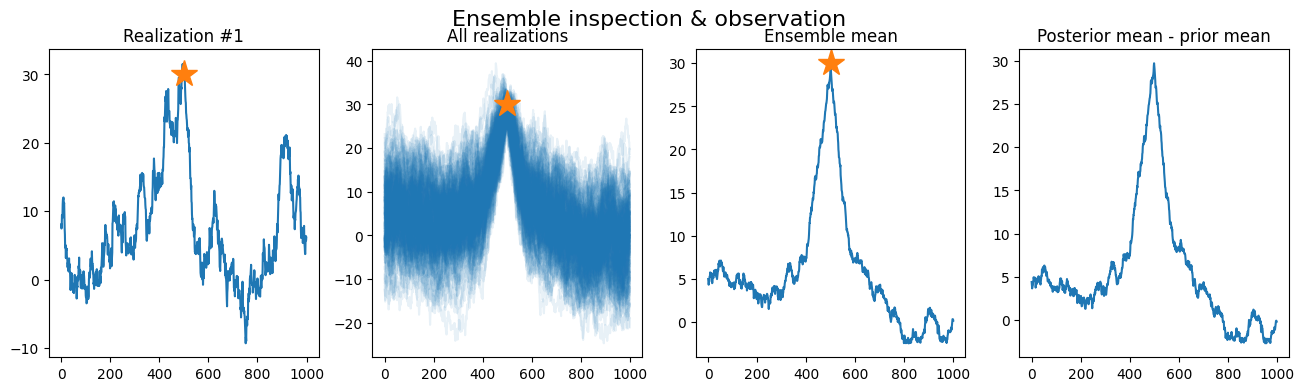

In [65]:
prior_mean = np.array(U.mean(axis=0))
plot_ensemble(U_posterior_es, d, prior_mean)

## EnIF high-level API

The high-level API consists of initialization, usually with a `Graph_u`, the noise precision `Prec_eps` and possibly the map `H`.
Then only two functions are needed `fit` and `transport` to arrive an updated (or analysed) ensemble.
To think of these know that 
- `fit` estimates a GMRF model w.r.t. the graph `Graph_u`, and learns a sparse affine map `H`. If `Prec_u` or `H` are passed, they are not re-fitted, but the low-level API can be used to update these if need be.
- `transport` takes the prior ensemble `U` and "transports" each realization to a realization of the posterior under the fitted GMRF and `H` model. More on the details here in the low-level API section.

In [66]:
gtmap = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps, H=H)
gtmap.fit(U, verbose_level=4)
prec_est_prior = gtmap.Prec_u.copy()
U_posterior_highlevel = gtmap.transport(U, Y, d, seed=42, verbose_level=10)

max degree of graph is: 4
Permutation optimization took 0.001847982406616211 seconds
Parameters in precision: 1999
Parameters in Cholesky factor: 2978
Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2894.23it/s]

Precision has log-determinant: -9.126853809069338
H mapping exists. Use `fit_H` to refit if necessary
Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=42
Sampled Gaussian noise with shape (200, 1)
Prior precision log-determinant: -9.126853809068976
Total residual variance: 1.0
Unexplained variance: 0.0
Measurement variance: 1.0
Posterior precision log-determinant: -5.048557046961635
Mapping canonical-scaled realizations to moment realization


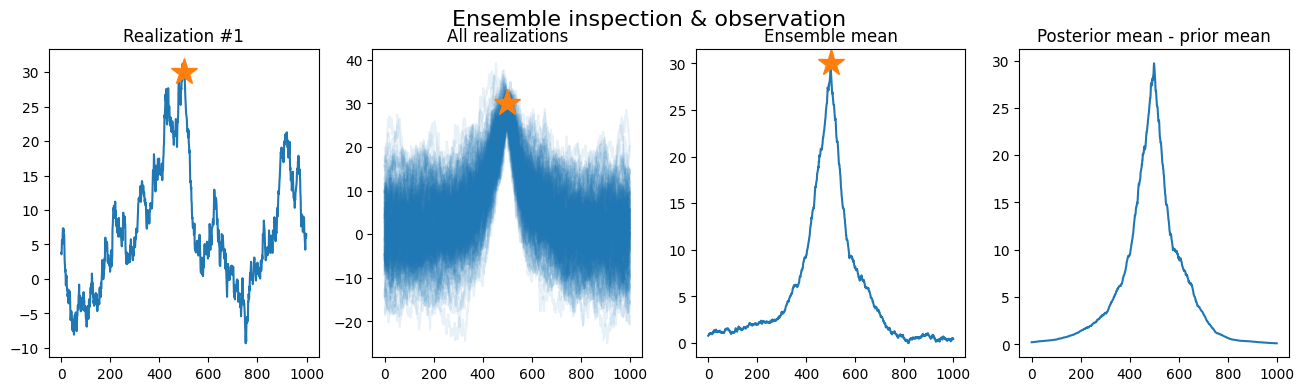

In [67]:
prior_mean = np.array(U.mean(axis=0))
plot_ensemble(U_posterior_highlevel, d, prior_mean)

## EnIF low-level API

### Sanity check #1: Equality of results

We now illustrate the low-level API, and check that it gives the same result as the high-level.

In [68]:
gtmap_lowlevel = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps, H=H)

#### Fit
When we call `fit`, we may estimate `Prec_u` as a GMRF w.r.t. `Graph_u`.
Also during `fit`, the mapping `H` may be estimated using `fit_H` that employes the LASSO for learning a sparse representation.

In [69]:
gtmap_lowlevel.fit_precision(U)
if gtmap_lowlevel.H is None:
    gtmap_lowlevel.fit_H(U, U@H.T) # simulations Y = U@H.T

Learning precision Cholesky factor row-by-row: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2790.82it/s]


#### Transport

The name `transport` comes from the field of measure-transport.
It does make sense in this context, because the function indeed transports each realization of prior to a realization of the posterior w.r.t. the GMRF on $(u,d)$ estimated by `fit`.

`transport` consists of three functions
- `pushforward_to_canonical`: transport realizations to "canonical" space
- `update_canonical`: update each canonical realization to a realization from the posterior, _and_ update the precision `Prec_u`
- `pullback_from_canonical`transport realizations back to physical space

where in-between, we sample some specific noisy residuals.

In [70]:
canonical = gtmap_lowlevel.pushforward_to_canonical(U)

# Work out residuals and associate unexplained variance
residual = gtmap_lowlevel.response_residual(U, Y)
eps = gtmap_lowlevel.generate_observation_noise(n, seed=42)
residual_noisy = residual + eps

canonical_posterior = gtmap_lowlevel.update_canonical(canonical, residual_noisy, d)
U_posterior_lowlevel = gtmap_lowlevel.pullback_from_canonical(canonical_posterior, iterative=True)

(200, 1000)


Mapping data to moment parametrisation realization-by-realization: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.79it/s]


In [71]:
canonical_posterior.shape

(200, 1000)

Note that `transport` could have used the Kalman-filter equations (conditioning with a multivariate Gaussian in the mean-precision parametrization).
It is however much more numerically efficient (and stable) to employ the Information-filter equations (conditioning with a multivariate Gaussian in the canonical parametrization) when working with a GMRF.

We plot to check the results are like before

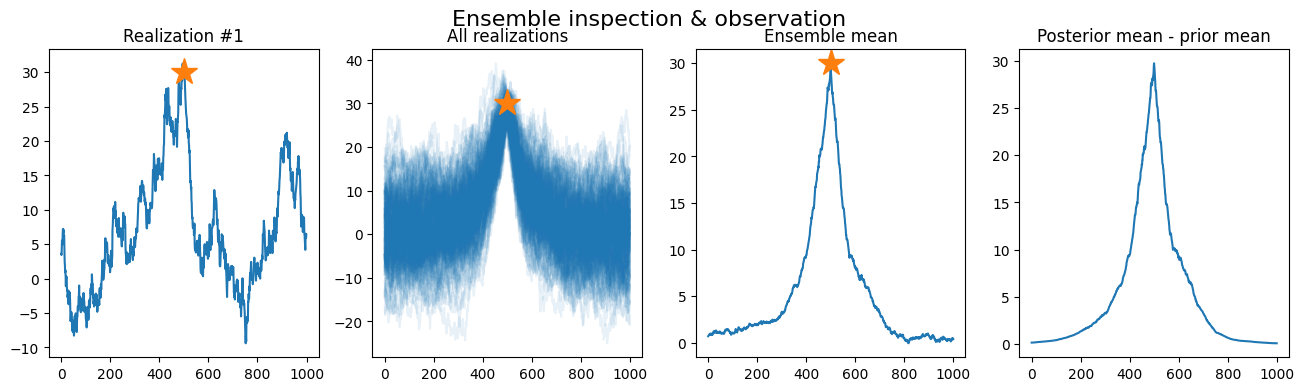

In [72]:
plot_ensemble(U_posterior_lowlevel, d, prior_mean)

The results look identical.

In [73]:
np.allclose(U_posterior_lowlevel, U_posterior_highlevel)

False

And indeed they are identical. When `seed` is different, the results should be distributionally equivalent.

### Sanity check #2: Using true precision

For this case, we do indeed have access to the true prior precision of the AR-1 process.
It is possible to pass this to `EnIF` upon initialization, and if `H` too is provided it is not necessary to run `fit`.
The case of a known precision is sometimes known, e.g. when doing pure parameter estimation, the prior we are sampling from can indeed be known, and is often transformed (for good reasons) to a multivariate standard normal.

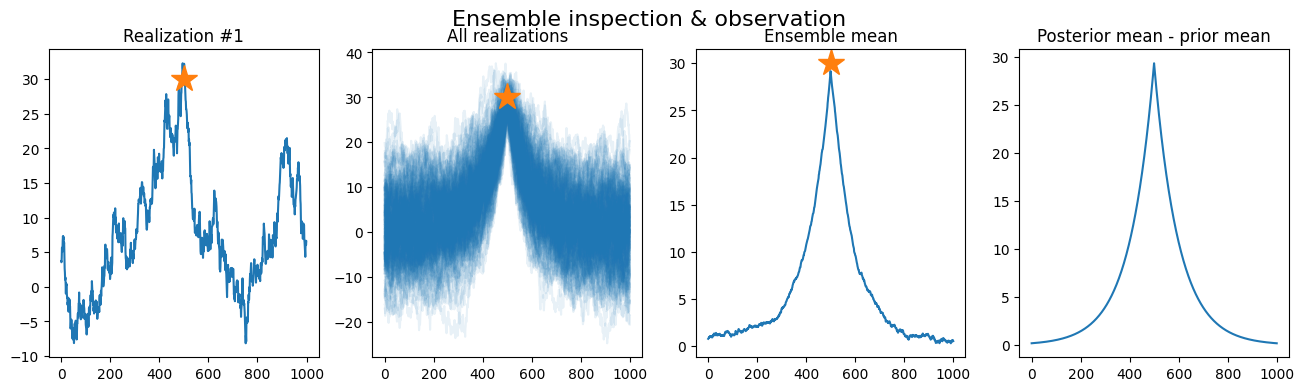

In [74]:
gtmap_prec_known = EnIF(Prec_u = Prec_u, Prec_eps=Prec_eps, H=H)

U_posterior = gtmap_prec_known.transport(U, Y, d)

plot_ensemble(U_posterior, d, prior_mean)

The results are _almost_ identical.
Note however that there is zero noise in the update.
This is because we have not estimated anything from data -- both `Prec_u` and `H` was provided apriori, exactly defining the Gaussian on $(u,d)$.

### Sanity check #3: Pullback of pushforward without update at canonical

We just decomposed `transport` to its three main parts, a pushforward, an update, and a pullback.
It is reasonable to think that if we skip the `update` in the middle,

In [22]:
gtmap_pullpush = EnIF(Prec_u = Prec_u, Prec_eps=Prec_eps, H=H)
canonical = gtmap_pullpush.pushforward_to_canonical(U)
U_posterior = gtmap_pullpush.pullback_from_canonical(canonical)

then the pullback of what we pushforwarded, should be the same as what we input

In [23]:
np.allclose(U, U_posterior, atol=1e-12)

True

which indeed seems to be the case.

## Estimating a sparse linear map

If `H` is not given, then it must be estimated from data `U` and `Y`.
We seek a linear map that learns
$$H = E[\nabla_u h(u)]$$ 
for some conceptual potentially non-linear map $h:u\mapsto y$.
Furthermore, we seek a sparse representation `H`, so that the posterior `Prec_u` retains sparsity.
To this end, `fit_H` implements linear L1 regression

In [24]:
gtmap_uninformed = EnIF(Graph_u=Graph_u, Prec_eps=Prec_eps)

Note that neither `Prec_u` or `H` is passed.
As such, they should both be learnt from data.

In [25]:
gtmap_uninformed.fit(U, Y, verbose_level=4)

max degree of graph is: 4
Permutation optimization took 0.0005521774291992188 seconds
Parameters in precision: 1999
Parameters in Cholesky factor: 2978
Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3025.77it/s]


Precision has log-determinant: -15.472556051252162
Learning sparse linear map of shape (1, 1000)


Learning sparse linear map for each response: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]

Total elements: 1000
Non-zero elements: 2
Fraction of non-zeros: 0.002
Calculating unexplained variance


Print the true and the (hopefully sparse) learnt map, to see if it looks correct

In [26]:
print("Original sparse matrix")
print(H) # true (unknown) map
print("Estimated sparse matrix")
print(gtmap_uninformed.H) # estimated (sparse) map

Original sparse matrix
  (0, 499)	1
Estimated sparse matrix
  (0, 498)	0.005243402056342818
  (0, 499)	0.993880120645363


As we see, the sparsity structure has been identified, and the value is very close to `1`.
We may then employ it for `transport` of the prior ensemble to a posterior ensemble

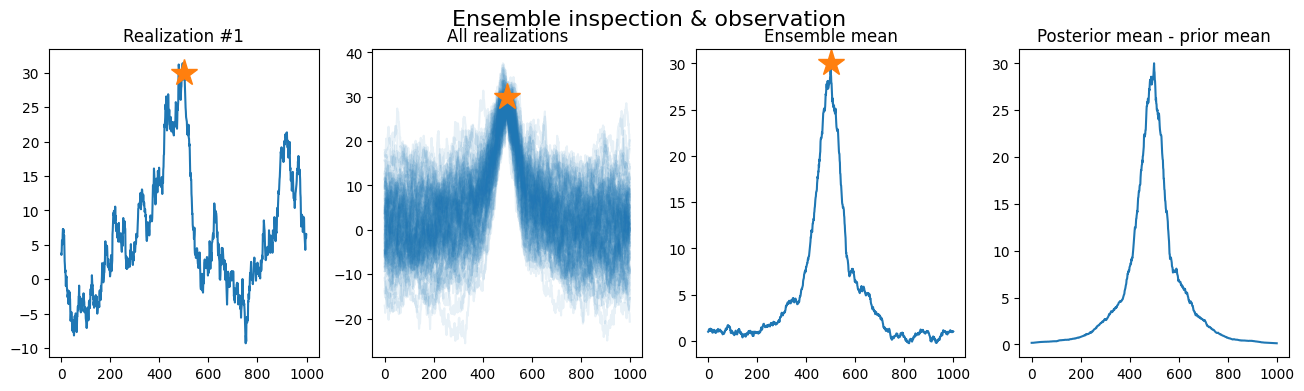

In [27]:
U_posterior = gtmap_uninformed.transport(U, Y, d)
plot_ensemble(U_posterior, d, prior_mean)

## Estimating a sparse linear map - Fast with influence adapted boosting

In [28]:
gtmap_uninformed_2 = EnIF(Graph_u=Graph_u, Prec_eps=Prec_eps)

In [29]:
gtmap_uninformed_2.fit(U, Y, learning_algorithm="influence-boost", verbose_level=4)

max degree of graph is: 4
Permutation optimization took 0.0006499290466308594 seconds
Parameters in precision: 1999
Parameters in Cholesky factor: 2978
Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3067.18it/s]


Precision has log-determinant: -15.472556051252162
Learning sparse linear map of shape (1, 1000)


Learning sparse linear map for each response: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.44it/s]

Total elements: 1000
Non-zero elements: 1
Fraction of non-zeros: 0.001
Calculating unexplained variance


In [30]:
print("Original sparse matrix")
print(H) # true (unknown) map
print("Estimated sparse matrix")
print(gtmap_uninformed_2.H) # estimated (sparse) map

Original sparse matrix
  (0, 499)	1
Estimated sparse matrix
  (0, 499)	0.9999980926513671


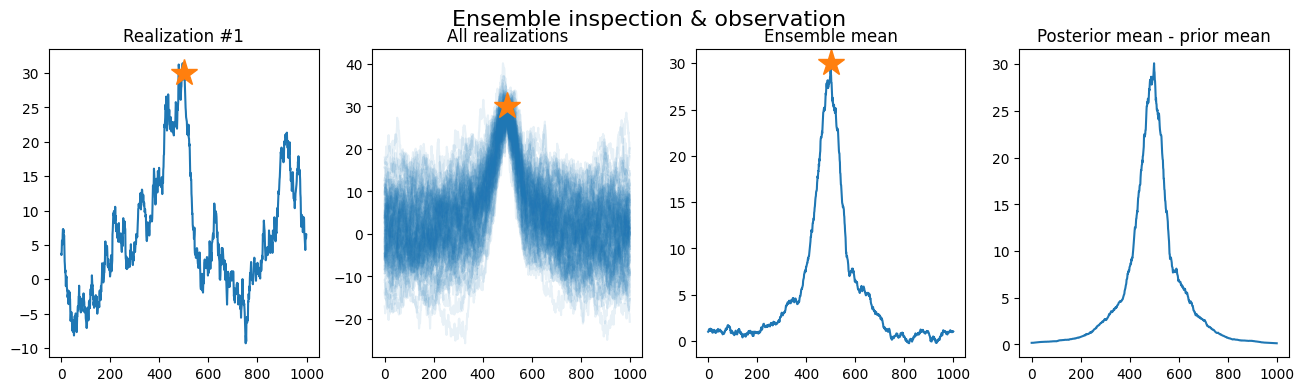

In [31]:
U_posterior = gtmap_uninformed_2.transport(U, Y, d)
plot_ensemble(U_posterior, d, prior_mean)

# New precision estimation

In [32]:
from tqdm import tqdm
import networkx as nx
from graphite_maps.precision_estimation import fit_precision_cholesky, precision_to_graph

G = Graph_u
G.remove_edges_from(nx.selfloop_edges(G))
p = G.number_of_nodes()
prec_full = sp.sparse.lil_matrix((p,p))
    
for i in tqdm(range(p)):
    ne_i = set(G.neighbors(i))
    nodes = [i] + list(ne_i)
    #Graph_u_sub = G.subgraph(nodes)
    U_sub = U[:,nodes]

    Graph_u_sub = nx.Graph()
    Graph_u_sub.add_nodes_from(range(len(nodes)))
    Graph_u_sub.add_edges_from([(0,iter+1) for iter in range(len(ne_i))])

    prec_sub, *_ = fit_precision_cholesky(U_sub, Graph_u_sub, verbose_level=0, ordering_method="metis", rowbyrow=False)

    prec_full[i,i] = prec_sub[0,0]
    for iter, j in enumerate(ne_i):
        prec_full[i,j] = prec_sub[0, iter+1]
        prec_full[j,i] = prec_sub[iter+1, 0]

prec_full = prec_full.tocsc()
print(prec_full.A)

  0%|                                                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]/Users/BERL/Github/venv_sksparse/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
 16%|████████████████████████████▏                                                                                                                                               | 164/1000 [00:02<00:12, 64.32it/s]/Users/BERL/Github/venv_sksparse/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
 45%|████████████████████████████████████████████████████████████████████████████▋              

[[ 1.25  -1.253  0.    ...  0.     0.     0.   ]
 [-1.253  2.27  -1.003 ...  0.     0.     0.   ]
 [ 0.    -1.003  2.051 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  2.375 -1.02   0.   ]
 [ 0.     0.     0.    ... -1.02   2.209 -1.137]
 [ 0.     0.     0.    ...  0.    -1.137  1.12 ]]


Precision u exists. Use `fit_precision` to refit if necessary
Learning sparse linear map of shape (1, 1000)


Learning sparse linear map for each response: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.96it/s]


Total elements: 1000
Non-zero elements: 1
Fraction of non-zeros: 0.001
Calculating unexplained variance
Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 1)
Total residual variance: 1.0000000001988734
Unexplained variance: 1.9887341723170726e-10
Measurement variance: 1.0
Mapping canonical-scaled realizations to moment realization


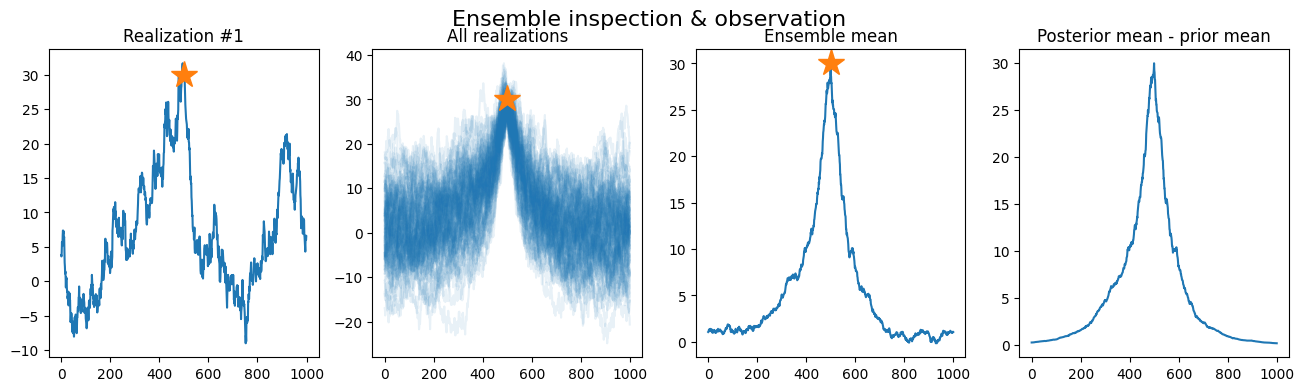

In [33]:
gtmap2 = EnIF(Prec_u = prec_full, Prec_eps=Prec_eps)
gtmap2.fit(U, Y, learning_algorithm="influence-boost", ordering_method="best", verbose_level=5)
U_posterior2 = gtmap2.transport(U, Y, d, verbose_level=5)
plot_ensemble(U_posterior2, d, prior_mean)

In [34]:
print(np.linalg.inv(prec_full.A))

[[53.261 52.334 51.9   ...  0.003  0.002  0.002]
 [52.334 52.208 51.774 ...  0.003  0.002  0.002]
 [51.9   51.774 52.333 ...  0.003  0.002  0.003]
 ...
 [ 0.003  0.003  0.003 ... 58.198 56.239 57.1  ]
 [ 0.002  0.002  0.002 ... 56.239 55.294 56.14 ]
 [ 0.002  0.002  0.003 ... 57.1   56.14  57.893]]


In [35]:
print(np.linalg.inv(prec_est_prior.A))

[[53.035 52.108 51.672 ...  0.001  0.001  0.001]
 [52.108 52.022 51.587 ...  0.001  0.001  0.001]
 [51.672 51.587 52.183 ...  0.001  0.001  0.001]
 ...
 [ 0.001  0.001  0.001 ... 58.051 56.059 56.876]
 [ 0.001  0.001  0.001 ... 56.059 55.12  55.924]
 [ 0.001  0.001  0.001 ... 56.876 55.924 57.673]]


In [183]:
from tqdm import tqdm
import networkx as nx
G = Graph_u
G.remove_edges_from(nx.selfloop_edges(G))
p = G.number_of_nodes()
prec_full = sp.sparse.lil_matrix((p,p))
for i in tqdm(range(p)):
    #print(i)
    ne_i = set(G.neighbors(i))
    #print(ne_i)
    U_sub_i = U[:,list(ne_i)]
    #print(ne_i)
    beta_i, *_ = np.linalg.lstsq(U_sub_i, U[:,i], rcond=None)
    #print(f"shapes: {U[:,i].shape} {beta.shape} {U_sub_i.shape}")
    e_i = U[:,i] - U_sub_i @ beta_i
    cov_i = np.cov(e_i, rowvar=False)
    #print(f"cov i: {cov_i}")
    prec_ii = 1/cov_i
    #print(f"prec i={i}: {prec_ii}")
    #prec_full[i,i] = prec_ii
    #print(cov_i)
    #print(beta)
    for j in ne_i:
        if j > i:
            #print(f"i: {i}, j: {j}")
            ne_j = set(G.neighbors(j))
            #print(f"neighbours of j={j}: {ne_j}")
            #U_sub_j = U[:,list(ne_j)]
            #beta_j, *_ = np.linalg.lstsq(U_sub_j, U[:,j], rcond=None)
            #e_j = U[:,j] - U_sub_j @ beta_j
            #cov_j = np.cov(e_j, rowvar=False)
            #prec_jj = 1.0 / cov_j
            #print(f"prec j={j}: {prec_jj}")
            #prec_full[i,i] = prec_jj

            ne_ij = set(G.neighbors(i)).union(set(G.neighbors(j)))
            ne_ij.remove(i)
            ne_ij.remove(j)
            #print(f"neighbours of i={i} and j={j}: {ne_ij}")
            if len(ne_ij) > 0:
                Z = U[:,list(ne_ij)]
                beta_i, *_ = np.linalg.lstsq(Z, U[:,i], rcond=None)
                beta_j, *_ = np.linalg.lstsq(Z, U[:,j], rcond=None)
                r_i = U[:,i] - Z @ beta_i
                r_j = U[:,j] - Z @ beta_j
            else:
                r_i = U[:,i]
                r_j = U[:,j]

            #print(f"COV R:\n {np.cov(r_i, r_j)}")
            #print(f"INV-COV R:\n {np.linalg.inv(np.cov(r_i, r_j))}")
            #print(f"CHECK THIS: {np.cov(r_i, r_j)[0,1] / np.sqrt(prec_ii * prec_jj)}")
            P11 = np.linalg.inv(np.cov(r_i, r_j))
            prec_full[i,i] = np.max([prec_full[i,i], P11[0,0]])
            prec_full[j,j] = np.max([prec_full[j,j], P11[1,1]])
            prec_full[i,j] = 1.1 * P11[0,1]
            prec_full[j,i] = prec_full[i,j]
            
prec_full = prec_full.tocsc()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13506.40it/s]


Precision u exists. Use `fit_precision` to refit if necessary
Learning sparse linear map of shape (1, 1000)


Learning sparse linear map for each response: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.57it/s]


Total elements: 1000
Non-zero elements: 1
Fraction of non-zeros: 0.001
Calculating unexplained variance
Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 1)
Total residual variance: 1.000000000032085
Unexplained variance: 3.208494238626179e-11
Measurement variance: 1.0
Mapping canonical-scaled realizations to moment realization


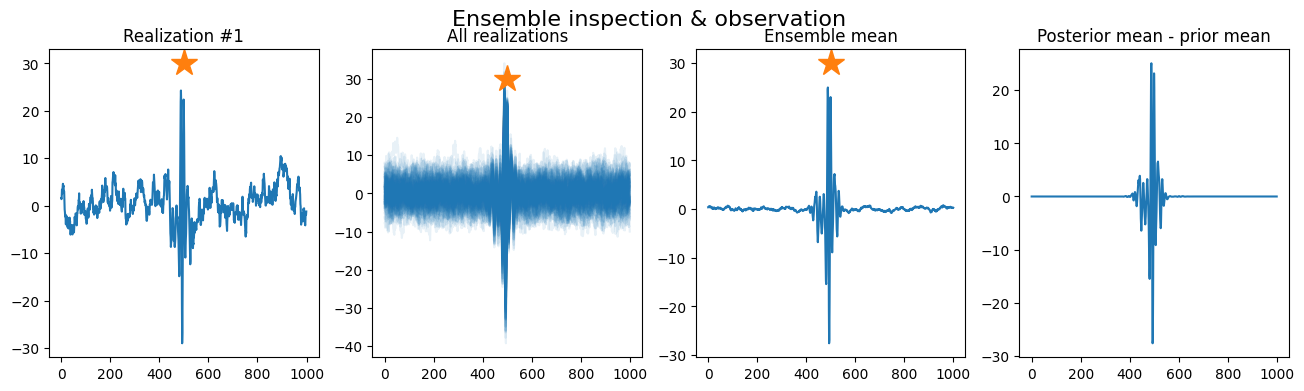

In [184]:
gtmap2 = EnIF(Prec_u = prec_full + 0.0001*sp.sparse.eye(p,p, format=prec_full.format), Prec_eps=Prec_eps)
gtmap2.fit(U, Y, learning_algorithm="influence-boost", ordering_method="best", verbose_level=5)
U_posterior2 = gtmap2.transport(U, Y, d, verbose_level=5)
plot_ensemble(U_posterior2, d, prior_mean)

In [185]:
print(prec_full)

  (0, 0)	1.1964283620963334
  (1, 0)	-1.375267111872205
  (0, 1)	-1.375267111872205
  (1, 1)	2.3273021148073543
  (2, 1)	-1.1756279205762301
  (1, 2)	-1.1756279205762301
  (2, 2)	1.876290472518463
  (3, 2)	-0.9547932142222556
  (2, 3)	-0.9547932142222556
  (3, 3)	1.9577099474934394
  (4, 3)	-1.1375598301078798
  (3, 4)	-1.1375598301078798
  (4, 4)	2.4089940841227064
  (5, 4)	-1.2609299924140014
  (4, 5)	-1.2609299924140014
  (5, 5)	1.879077411549613
  (6, 5)	-0.6246369689027595
  (5, 6)	-0.6246369689027595
  (6, 6)	1.6859588450261733
  (7, 6)	-0.9641614484235876
  (6, 7)	-0.9641614484235876
  (7, 7)	2.1233683184913397
  (8, 7)	-1.0017518031962167
  (7, 8)	-1.0017518031962167
  (8, 8)	1.7935759457236564
  :	:
  (991, 991)	2.929308632703849
  (992, 991)	-1.29044260692244
  (991, 992)	-1.29044260692244
  (992, 992)	1.7014757690988978
  (993, 992)	-0.8560490500469445
  (992, 993)	-0.8560490500469445
  (993, 993)	1.9024823390742809
  (994, 993)	-0.8490652599874825
  (993, 994)	-0.8490652599

In [186]:
print(prec_est_prior)

  (0, 0)	1.149594179646278
  (1, 0)	-1.132810000554664
  (0, 1)	-1.132810000554664
  (1, 1)	2.104644323298267
  (2, 1)	-0.9309028449532213
  (1, 2)	-0.9309028449532213
  (3, 2)	-0.8756439946658794
  (2, 2)	1.8616435816504255
  (4, 2)	-0.10190375301125248
  (3, 3)	1.8641697455130357
  (2, 3)	-0.8756439946658794
  (4, 3)	-0.9501477951581727
  (3, 4)	-0.9501477951581727
  (2, 4)	-0.10190375301125248
  (5, 4)	-1.0973977354000226
  (6, 4)	-0.04557114919735189
  (4, 4)	2.1855829274739826
  (8, 4)	0.05016810115588566
  (5, 5)	1.7546963908720818
  (6, 5)	-0.6940009549611401
  (4, 5)	-1.0973977354000226
  (7, 6)	-0.860072994661408
  (5, 6)	-0.6940009549611401
  (6, 6)	1.8392726159159836
  (4, 6)	-0.04557114919735189
  :	:
  (992, 993)	-0.7340932073593781
  (993, 993)	1.8196556807401618
  (995, 993)	-0.11952280990160091
  (991, 993)	-0.2540066239557525
  (994, 994)	2.1878487001545137
  (993, 994)	-0.8046457692097838
  (995, 994)	-1.3014986650896267
  (996, 995)	-1.058164035224276
  (997, 995)	0.

In [37]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
from scipy.sparse.linalg import inv
from numpy.linalg import pinv

def get_precision_nonzero(Neighbours, markov_order):
    if markov_order == 0:
        p = Neighbours.shape[0]
        return identity(p, format='csr')
    G = Neighbours.copy()
    for order in range(1, markov_order):
        G = G.dot(Neighbours)
    G.data[:] = 1.0  # All nonzero entries set to 1
    return G

def create_bi(Z, j):
    p = Z.shape[1]
    row_values = []
    data_values = []
    col_indices = []
    for i in range(Z.indptr[j], Z.indptr[j + 1]):
        row_index = Z.indices[i]
        row_values.append(row_index)
        data_values.append(1.0)  # Set value to 1.0 as per the structure needed
        col_indices.append(i - Z.indptr[j])  # Local column index for non-zero structure
    Bi = coo_matrix((data_values, (row_values, col_indices)), shape=(p, len(data_values))).tocsr()
    return Bi

def ensure_symmetry(M):
    # Symmetrize the matrix M
    return (M + M.T) / 2

def prec_sparse(X, Graph, markov_order=1, symmetrization=True):
    p = X.shape[1]
    Ip = np.eye(p)
    Prec = lil_matrix((p, p))  # Using LIL format for efficient assignments
    Z = get_precision_nonzero(Graph, markov_order)
    prec_mat_triplet = []

    for j in range(p):
        #print("j", j)
        Bi = create_bi(Z, j).tocsc()  # Ensure CSC for matrix multiplication
        xbi = X @ Bi

        cov_ml_est = np.cov(xbi, rowvar=False) + 0.05 * np.eye(Bi.shape[1])
        
        wi1 = pinv(cov_ml_est) @ (Bi.T @ Ip[:, j])
        #print(f"wi1:\n {wi1}")

        rows, cols = Bi.nonzero()
        for i, k in zip(rows, cols):
            #print("triplet: ", (i, j, wi1[k]))
            prec_mat_triplet.append((i, j, wi1[k]))


    # Assign triplets to Prec
    for triplet in prec_mat_triplet:
        #print(triplet)
        i, j, value = triplet
        Prec[i, j] = value

    Prec = Prec.tocsr()  # Convert to CSR for final operations
    #if symmetrization:
    #    Prec = ensure_symmetry(Prec)

    return Prec

In [38]:
# Example usage:
X = U.copy()
from graphite_maps.precision_estimation import graph_to_precision_matrix
Graph_mat = graph_to_precision_matrix(Graph_u)
Graph_mat.data[:] = 1.0
precision_matrix = prec_sparse(X, Graph_mat)
print("Estimated Precision Matrix:\n", precision_matrix.toarray())

Estimated Precision Matrix:
 [[ 1.066 -1.06   0.    ...  0.     0.     0.   ]
 [-1.05   1.983 -0.818 ...  0.     0.     0.   ]
 [ 0.    -0.888  1.632 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  1.848 -0.744  0.   ]
 [ 0.     0.     0.    ... -0.765  1.686 -0.974]
 [ 0.     0.     0.    ...  0.    -0.865  0.984]]


Precision u exists. Use `fit_precision` to refit if necessary
Learning sparse linear map of shape (1, 1000)


Learning sparse linear map for each response: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.67it/s]


Total elements: 1000
Non-zero elements: 1
Fraction of non-zeros: 0.001
Calculating unexplained variance
Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 1)
Total residual variance: 1.000000000032085
Unexplained variance: 3.208494238626179e-11
Measurement variance: 1.0
Mapping canonical-scaled realizations to moment realization
(100, 1000)


Mapping data to moment parametrisation realization-by-realization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 308.79it/s]


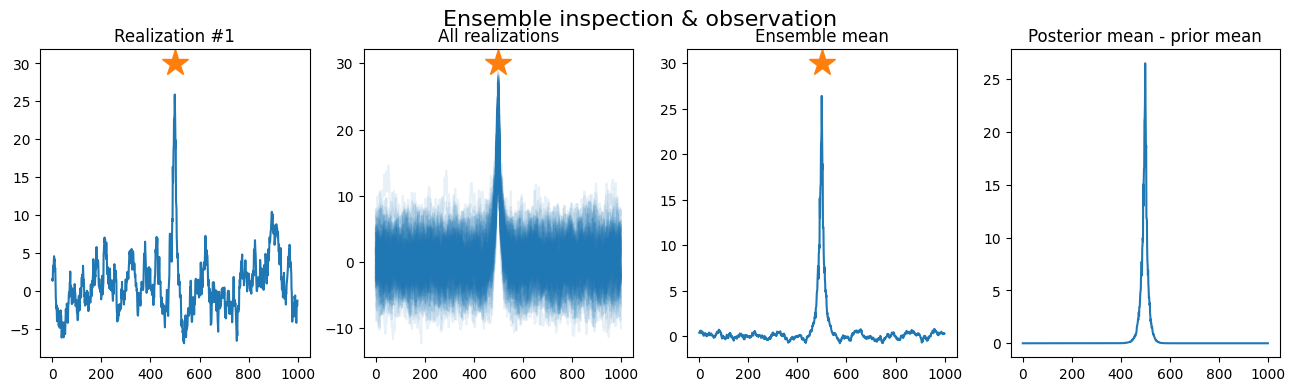

In [39]:
gtmap2 = EnIF(Prec_u = precision_matrix, Prec_eps=Prec_eps)
gtmap2.fit(U, Y, learning_algorithm="influence-boost", ordering_method="best", verbose_level=5)
U_posterior2 = gtmap2.transport(U, Y, d, verbose_level=5, iterative=True)
plot_ensemble(U_posterior2, d, prior_mean)